In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def relu(Z):
    R=np.maximum(0,Z)
    return R

In [3]:
def sigmoid(Z):
    S=1/(1+np.exp(-1*Z))
    return S

In [4]:
def relu_derivative(Z):
    Z[Z>=0]=1
    Z[Z<0]=0
    return Z

In [5]:
def sigmoid_derivative(Z):
    SD=sigmoid(Z)*(1-sigmoid(Z))
    return SD

In [6]:
class Model():
    def __init__(self):
        self.layers = []
        self.L = 0
        self.W = {}
        self.b = {}
        self.A = {}
        self.Z = {}
        self.dA = {}
        self.dZ = {}
        self.dW = {}
        self.db = {}
        self.cost = 0.
        self.m = 0
        self.lam = 0
        self.cost_history = []
        self.acc_history = []
        self.alpha_history = []
        self.alpha = 0.
        self.iterations = 0
    
    def add_layers(self, list_of_layers):
        self.layers = list_of_layers
        self.L = len(self.layers) - 1 # Number of layers excluding the input feature layer
    
    def init_params(self):
        for i in range(1, self.L + 1):
            self.W[str(i)] = np.random.randn(self.layers[i], self.layers[i - 1]) * np.sqrt(2. / self.layers[i - 1])
            self.b[str(i)] = np.zeros((self.layers[i], 1))
    
    def forward_prop(self, X):
        self.A['0'] = X
        
        for i in range(1, self.L + 1):
            self.Z[str(i)] = np.dot(self.W[str(i)], self.A[str(i - 1)]) + self.b[str(i)]
            if i == self.L:
                # Output layer, Sigmoid activation
                self.A[str(i)] = sigmoid(self.Z[str(i)])
            else:
                # Hidden layer, Relu activataion
                self.A[str(i)] = relu(self.Z[str(i)])
    
    def compute_cost(self, Y):
        self.cost = -1 * np.sum(np.multiply(Y, np.log(self.A[str(self.L)])) + 
                           np.multiply(1 - Y, np.log(1 - self.A[str(self.L)]))) / self.m 
        
        if self.lam != 0:
            reg = (self.lam / (2 * self.m))
            for i in range(1, self.L + 1):
                reg += np.sum(np.dot(self.W[str(i)], self.W[str(i)].T))
            self.cost += reg
            
        self.cost_history.append(self.cost)
    
    def backward_prop(self, Y):
        # We need dA[str(L)] to start the backward prop computation
        self.dA[str(self.L)] = -1 * (np.divide(Y, self.A[str(self.L)]) - np.divide(1 - Y, 1 - self.A[str(self.L)]))
        self.dZ[str(self.L)] = np.multiply(self.dA[str(self.L)], sigmoid_derivative(self.Z[str(self.L)]))
        self.dW[str(self.L)] = np.dot(self.dZ[str(self.L)], self.A[str(self.L - 1)].T) / self.m + (self.lam/self.m) * self.W[str(self.L)]
        self.db[str(self.L)] = np.sum(self.dZ[str(self.L)], axis = 1, keepdims = True) / self.m
        self.dA[str(self.L - 1)] = np.dot(self.W[str(self.L)].T, self.dZ[str(self.L)])
            
        for i in reversed(range(1, self.L)):

            self.dZ[str(i)] = np.multiply(self.dA[str(i)], relu_derivative(self.Z[str(i)]))
            self.dW[str(i)] = np.dot(self.dZ[str(i)], self.A[str(i - 1)].T) / self.m + (self.lam/self.m) * self.W[str(i)]
            self.db[str(i)] = np.sum(self.dZ[str(i)], axis = 1, keepdims = True) / self.m
            self.dA[str(i - 1)] = np.dot(self.W[str(i)].T, self.dZ[str(i)])
    
    def update_params(self):
        for i in range(1, self.L + 1):
            self.W[str(i)] = self.W[str(i)] - self.alpha * self.dW[str(i)]
            self.b[str(i)] = self.b[str(i)] - self.alpha * self.db[str(i)]
    
    def train(self, X, Y, iterations = 10, 
        alpha = 0.001, decay = True, decay_iter = 5, decay_rate = 0.9, stop_decay_counter = 100,
        verbose = True, lam = 0):
        
        self.m = Y.shape[1]
        self.alpha = alpha
        self.iterations = iterations
        self.lam = lam
        
        # initialize parameters
        self.init_params()

        for i in range(iterations):
            # forward prop
            self.forward_prop(X)
            # compute cost
            self.compute_cost(Y)
            # backward prop
            self.backward_prop(Y)
            # update params
            self.update_params()
            # evaluate
            self.acc_history.append(self.evaluate(X, Y, in_training = True))
            # save alpha
            self.alpha_history.append(self.alpha)
            # learning rate decay
            if decay and stop_decay_counter > 0 and i % decay_iter == 0:
                self.alpha = decay_rate * self.alpha
                stop_decay_counter -= 1
            # display cost per iteration
            if verbose:
                print('Cost after {} iterations: {}'.format(i, self.cost))
    
    def predict(self, X, in_training = False):
        if in_training == False:
            self.forward_prop(X)
            
        preds = self.A[str(self.L)] >= 0.5
        preds = np.squeeze(preds)
        return preds
        
    def evaluate(self, X, Y, in_training = False):
        examples = X.shape[1]
        
        pred = self.predict(X, in_training = in_training)
        pred = pred.reshape(1, examples)
        diff = np.sum(abs(pred - Y))
        acc = (examples - np.sum(diff)) / examples
        return acc
    
    def plot_cost(self):
        plt.plot(range(self.iterations), self.cost_history, color = 'b')
        plt.show()
    
    def plot_acc(self):
        plt.plot(range(self.iterations), self.acc_history, color = 'r')
        plt.show()
    
    def plot_alpha(self):
        plt.plot(range(self.iterations), self.alpha_history, color = 'g')
        plt.show()


# Testing the Model

In [7]:
m = Model()
m.add_layers([2, 2, 1])
X = np.array([
    [1., 0., 0., 0., -10., 9.],
    [0., 1., 0., -6., -4., -1.]
])
Y = np.array([1, 1, 1, 0, 0, 1])
Y = Y.reshape(1, 6)

In [8]:
m.train(X, Y, iterations = 50, alpha = 0.1, verbose = False)

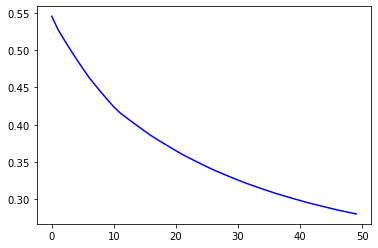

In [9]:
m.plot_cost()


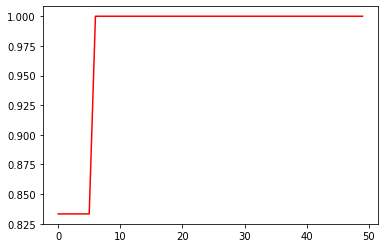

In [10]:
m.plot_acc()

In [11]:
print(m.evaluate(X, Y))

1.0


In [12]:
print(m.predict(X))

[ True  True  True False False  True]


In [13]:
import pandas as pd

data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data', sep = ',', header = None)
data.head()

,0,1,2,3
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


We have three features and one class. 1 means that the patient survived for 5 years or longer and 2 means that the patient died within 5 years.

In [14]:
X_train = data.iloc[:,:-1]
Y_train = data.iloc[:, -1]

In [15]:
X_train

,0,1,2
0,30,64,1
1,30,62,3
2,30,65,0
3,31,59,2
4,31,65,4
...,...,...,...
301,75,62,1
302,76,67,0
303,77,65,3
304,78,65,1


In [16]:
Y_train

0      1
1      1
2      1
3      1
4      1
      ..
301    1
302    1
303    1
304    2
305    2
Name: 3, Length: 306, dtype: int64

In [17]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
Y_train = Y_train.reshape(Y_train.shape[0], 1)

In [18]:
X_train

array([[30, 64,  1],
       [30, 62,  3],
       [30, 65,  0],
       [31, 59,  2],
       [31, 65,  4],
       [33, 58, 10],
       [33, 60,  0],
       [34, 59,  0],
       [34, 66,  9],
       [34, 58, 30],
       [34, 60,  1],
       [34, 61, 10],
       [34, 67,  7],
       [34, 60,  0],
       [35, 64, 13],
       [35, 63,  0],
       [36, 60,  1],
       [36, 69,  0],
       [37, 60,  0],
       [37, 63,  0],
       [37, 58,  0],
       [37, 59,  6],
       [37, 60, 15],
       [37, 63,  0],
       [38, 69, 21],
       [38, 59,  2],
       [38, 60,  0],
       [38, 60,  0],
       [38, 62,  3],
       [38, 64,  1],
       [38, 66,  0],
       [38, 66, 11],
       [38, 60,  1],
       [38, 67,  5],
       [39, 66,  0],
       [39, 63,  0],
       [39, 67,  0],
       [39, 58,  0],
       [39, 59,  2],
       [39, 63,  4],
       [40, 58,  2],
       [40, 58,  0],
       [40, 65,  0],
       [41, 60, 23],
       [41, 64,  0],
       [41, 67,  0],
       [41, 58,  0],
       [41, 5

In [19]:
Y_train

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [2],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [2],
       [1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [2],
    

In [20]:
print(X_train.shape)

(306, 3)


In [21]:
print(Y_train.shape)

(306, 1)


In [22]:
mean = np.mean(X_train, axis = 0)
mean

array([52.45751634, 62.85294118,  4.02614379])

In [23]:
variance = np.var(X_train, axis = 0)
variance

array([116.33316246,  10.52412534,  51.52219232])

In [24]:
X_train = np.divide((X_train - mean), variance)
X_train

array([[-1.93044837e-01,  1.08993269e-01, -5.87347637e-02],
       [-1.93044837e-01, -8.10462769e-02, -1.99165397e-02],
       [-1.93044837e-01,  2.04013042e-01, -7.81438757e-02],
       [-1.84448835e-01, -3.66105596e-01, -3.93256517e-02],
       [-1.84448835e-01,  2.04013042e-01, -5.07427764e-04],
       [-1.67256833e-01, -4.61125369e-01,  1.15947244e-01],
       [-1.67256833e-01, -2.71085823e-01, -7.81438757e-02],
       [-1.58660832e-01, -3.66105596e-01, -7.81438757e-02],
       [-1.58660832e-01,  2.99032815e-01,  9.65381321e-02],
       [-1.58660832e-01, -4.61125369e-01,  5.04129484e-01],
       [-1.58660832e-01, -2.71085823e-01, -5.87347637e-02],
       [-1.58660832e-01, -1.76066050e-01,  1.15947244e-01],
       [-1.58660832e-01,  3.94052588e-01,  5.77199082e-02],
       [-1.58660832e-01, -2.71085823e-01, -7.81438757e-02],
       [-1.50064831e-01,  1.08993269e-01,  1.74174580e-01],
       [-1.50064831e-01,  1.39734960e-02, -7.81438757e-02],
       [-1.41468830e-01, -2.71085823e-01

In [25]:

Y_train = Y_train - 1
Y_train
# Changing label 1 to 0 and label 2 to 1

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
    

In [26]:

# Split the data into test and train sets
from sklearn.utils import shuffle

X_train, Y_train = shuffle(X_train, Y_train)

X_test = X_train[250:,:]
Y_test = Y_train[250:,:]

X_train_ = X_train[:250,:]
Y_train_ = Y_train[:250,:]

print(X_train_.shape)
print(Y_train_.shape)
print(X_test.shape)
print(Y_test.shape)

(250, 3)
(250, 1)
(56, 3)
(56, 1)


In [27]:
# Split the data into test and train sets
from sklearn.utils import shuffle
X_train_ = X_train_.reshape(3, 250)
Y_train_ = Y_train_.reshape(1, 250)
X_test  = X_test.reshape(3, 56)
Y_test  = Y_test.reshape(1, 56)

In [28]:

m = Model()
m.add_layers([3, 16, 16, 1])

m.train(X_train_, Y_train_, alpha = 0.9, decay_rate = 0.98, decay_iter = 10, stop_decay_counter = 100, 
        iterations = 5000, verbose = False, lam = 2)

In [29]:
print('Test set acc = ', m.evaluate(X_test, Y_test))

Test set acc =  0.6964285714285714


In [30]:
print(m.evaluate(X, Y))

ValueError: shapes (16,3) and (2,6) not aligned: 3 (dim 1) != 2 (dim 0)

In [ ]:
print(m.predict(X))